# **NLP Disaster Tweets Classification**

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import re
import string
from collections import defaultdict, Counter
from bayes_opt import BayesianOptimization
import torch.optim as optim


## **1. Problem Description and Data Overview (5 pts)**

The challenge involves a Natural Language Processing (NLP) task to classify tweets into disaster-related (target = 1) or non-disaster-related (target = 0) categories. NLP focuses on the interaction between computers and human language, processing and analyzing large amounts of natural language data.

### **Dataset:**
- **Size:** The dataset contains approximately 10,000 rows, each representing a tweet.
- **Dimensions:** There are 5 columns: `id`, `keyword`, `location`, `text`, and `target`.
- **Structure:** 
  - `id`: A unique identifier for each tweet.
  - `keyword`: A keyword from the tweet, often related to the disaster.
  - `location`: The location from which the tweet was sent.
  - `text`: The actual content of the tweet.
  - `target`: The label indicating if the tweet is related to a disaster (1) or not (0).



## **2. Exploratory Data Analysis (EDA) — Inspect, Visualize, and Clean the Data**


### **EDA Summary:**
- **Simple Inspection:** Below is a simple display of the first 5 rows of the dataset:

In [92]:
PATH = "./nlp-getting-started"

# Load the dataset
train_data = pd.read_csv(PATH + '/train.csv')
test_data = pd.read_csv(PATH + '/test.csv')

# Display the first 5 rows of the dataset
print(train_data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


- **Target Distribution:** The target variable’s distribution is slightly imbalanced, with more non-disaster-related tweets.

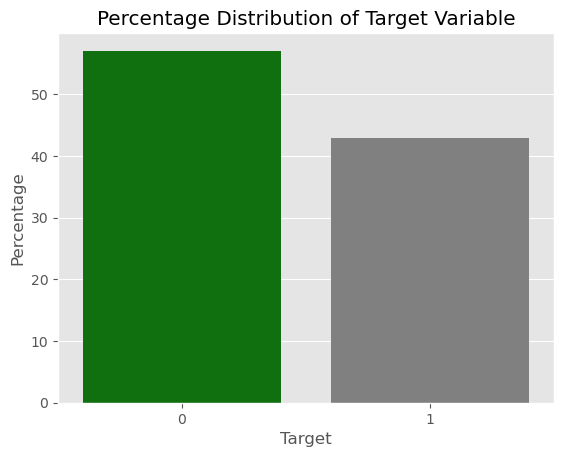

In [93]:
target_percentage = train_data['target'].value_counts(normalize=True) * 100

colors = ['green', 'grey']

sns.barplot(x=target_percentage.index, y=target_percentage.values, hue=target_percentage.index, palette=colors, dodge=False)
plt.title('Percentage Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()



- **Missing Values:** The `keyword` and `location` columns have missing values. Below is the percentage of missing values in train/test data.


In [94]:
missing_percentage_train = train_data[['keyword', 'location']].isnull().mean() * 100
missing_percentage_test = test_data[['keyword', 'location']].isnull().mean() * 100

print("Percentage of Missing keywords/locations in Train Data:")
print(missing_percentage_train)

print("\nPercentage of Missing keywords/locations in Test Data:")
print(missing_percentage_test)

Percentage of Missing keywords/locations in Train Data:
keyword      0.801261
location    33.272035
dtype: float64

Percentage of Missing keywords/locations in Test Data:
keyword      0.796813
location    33.864542
dtype: float64


- **Keyword and Location Analysis:** Certain keywords and locations were calculated.

In [95]:
# frequency of the top 15 keywords
keyword_counts = train_data['keyword'].value_counts().head(15).reset_index()
keyword_counts.columns = ['Keyword', 'Count']

# frequency of the top 15 locations
location_counts = train_data['location'].value_counts().head(15).reset_index()
location_counts.columns = ['Location', 'Count']

combined_table = pd.concat([keyword_counts, location_counts], axis=1)

print("Top 10 Keywords and Locations:")
print(combined_table)

Top 10 Keywords and Locations:
        Keyword  Count         Location  Count
0    fatalities     45              USA    104
1        deluge     42         New York     71
2    armageddon     42    United States     50
3       sinking     41           London     45
4        damage     41           Canada     29
5          harm     41          Nigeria     28
6   body%20bags     41               UK     27
7      outbreak     40  Los Angeles, CA     26
8      evacuate     40            India     24
9          fear     40           Mumbai     22
10     collided     40   Washington, DC     21
11        siren     40            Kenya     20
12      twister     40        Worldwide     19
13    windstorm     40        Australia     18
14     sinkhole     39      Chicago, IL     18


- **Text Length:** The length of the text varies between disaster and non-disaster tweets, which can be a distinguishing factor.

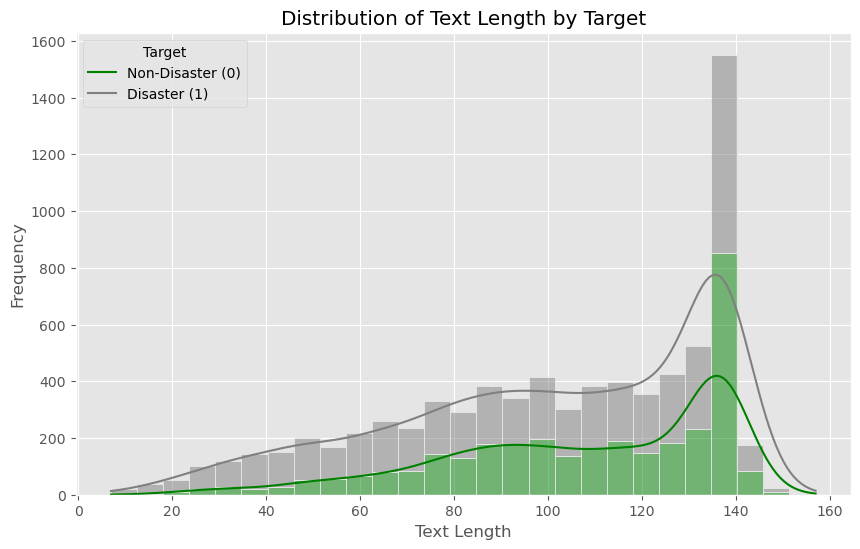

In [96]:

train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='text_length', hue='target', multiple='stack', kde=True, palette={0: 'gray', 1: 'green'})
plt.title('Distribution of Text Length by Target')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Target', labels=['Non-Disaster (0)', 'Disaster (1)'])
plt.show()


### **Data Cleaning:**
- Missing values were handled, text data was preprocessed (handled stop words, etc.)


In [97]:
# load the nltk library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/ning/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [98]:

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text


train_data['cleaned_text'] = train_data['text'].apply(clean_text)
train_data['tokenized_text'] = train_data['cleaned_text'].apply(word_tokenize)

## **3. Model Architecture**
### **Text Processing Strategy**

When deciding on the text processing strategy, it’s crucial to choose methods that best represent the linguistic features and context of the text data. Below, I’ll discuss the two strategies—TF-IDF and Word Embeddings—with a focus on why we'll use GloVe for our project.

- **Word Embeddings (e.g., GloVe):**
  - **Advantages:**
    - **Captures Semantic Relationships:** Word embeddings like GloVe encode words into dense vectors where semantic relationships are captured. For instance, vectors for words like "king" and "queen" or "car" and "vehicle" are positioned close to each other in the vector space.
    - **Contextual Understanding:** GloVe embeddings consider the global context in which words appear, leading to a richer representation of words and better generalization in downstream tasks.
    - **Transfer Learning:** Pre-trained GloVe embeddings are available, allowing us to leverage large-scale text data from sources like Wikipedia or Twitter, even if our dataset is relatively small.

- **TF-IDF:**
  - **Advantages:**
    - **Simplicity:** TF-IDF is straightforward to implement and interpret. It’s effective for tasks where understanding the importance of words relative to each document and the entire corpus is necessary.
    - **Sparsity:** The resulting matrix is often sparse, making it computationally efficient for algorithms that work well with sparse data, such as linear models or SVMs.
    - **Feature Importance:** TF-IDF naturally downweights common words (like "the," "is") and emphasizes more unique words, helping the model to focus on more informative features.

  - **Limitations:**
    - **Lack of Context:** TF-IDF treats words as independent features and does not capture the semantic meaning or context in which words appear.
    - **No Semantic Relationships:** Words with similar meanings (e.g., "car" and "vehicle") are treated as completely unrelated, which can limit the model’s ability to generalize.



#### **Rationale for Choosing GloVe**

- **Rich Representation:** For a task like disaster tweet classification, understanding the nuances and context in which words are used is vital. GloVe embeddings provide a more meaningful representation of words compared to TF-IDF, making them well-suited for our task.
- **Handling Out-of-Vocabulary Words:** GloVe embeddings, trained on large corpora, offer a broader vocabulary, reducing the impact of out-of-vocabulary words that may not be well represented in smaller, task-specific datasets.
- **Improved Generalization:** By using GloVe, we can improve the model’s ability to generalize to unseen data, especially in capturing the semantic relationships crucial for understanding disaster-related language.


#### **Model: Rationale for Choosing LSTM**

- **Effective for Sequential Data:** LSTMs excel at processing sequences, making them ideal for tweets where word order and context are crucial.
- **Captures Long-Term Dependencies:** LSTMs are designed to retain information over long sequences, ensuring that important context from earlier in the tweet influences the overall classification.
- **Proven in NLP:** LSTMs are widely used in NLP tasks due to their ability to handle the vanishing gradient problem, making them reliable for tasks like disaster tweet classification.


In [ ]:
tokenized_tweets = train_data['tokenized_text'].tolist()

MAX_VOCAB_SIZE, MAX_SEQ_LENGTH = 20000, 100
EMBEDDING_DIMENSION = 100
NUM_EPOCHS = 20

word_to_index = defaultdict(int)
for tweet in tokenized_tweets:
    for word in tweet:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index) + 1

indexed_sequences = [[word_to_index[word] for word in tweet] for tweet in tokenized_tweets]

# pad sequences to a fixed length
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, :len(seq)] = np.array(seq)
    return padded_sequences

padded_tweets = pad_sequences(indexed_sequences, MAX_SEQ_LENGTH)

glove_embeddings = GloVe(name='6B', dim=EMBEDDING_DIMENSION, cache='./cache')

embedding_matrix = np.zeros((len(word_to_index) + 1, EMBEDDING_DIMENSION))
for word, index in word_to_index.items():
    if word in glove_embeddings.stoi:
        embedding_matrix[index] = glove_embeddings.vectors[glove_embeddings.stoi[word]].numpy()
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [100]:
class TweetData(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.sequences[idx], self.labels[idx]
        return self.sequences[idx]

X_train, X_val, y_train, y_val = train_test_split(padded_tweets, train_data['target'].values, test_size=0.2, random_state=230)

y_train_tensor = torch.tensor(y_train.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.astype(np.float32)).unsqueeze(1)

train_dataset = TweetData(torch.tensor(X_train, dtype=torch.long), y_train_tensor)
val_dataset = TweetData(torch.tensor(X_val, dtype=torch.long), y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


### **Model Definition**

The `TextClassificationModel` class is defined, which is a simple neural network model for text classification. The model uses a pre-trained embedding matrix, followed by an average pooling layer and a fully connected layer to output class probabilities.


In [101]:
class TextClassificationModel(nn.Module):
    def __init__(self, embedding_matrix, num_classes):
        super(TextClassificationModel, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze the embedding weights
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        output = self.fc(pooled)
        return output

### **Training Function**
The `train_model` function is provided below, which handles the training loop. It includes training the model over several epochs, calculating the loss, and updating the model's weights. It also tracks and prints the training and validation losses for each epoch.

In [102]:
def plot_learning_curve(train_losses, val_losses):
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 6))
    
    plt.plot(train_losses, label='Train Loss', color='blue', linestyle='--', marker='o', linewidth=2, markersize=6)
    plt.plot(val_losses, label='Validation Loss', color='green', linestyle='-', marker='x', linewidth=2, markersize=6)
    
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.xlabel('Epoch Number', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Model Training Progress', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=12, loc='upper right', fancybox=True, shadow=True, borderpad=1)
    
    plt.show()


def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for texts, targets in val_loader:
            outputs = model(texts)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(all_targets, all_predictions)
    return val_loss, val_f1


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for texts, targets in train_loader:
            outputs = model(texts)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        val_loss, val_f1 = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} | Training Loss: {avg_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation F1: {val_f1:.4f}')

    plot_learning_curve(train_losses, val_losses)

### **Model Evaluation**
The `evaluate_model` computes the F1 score, accuracy, and generates a classification report along with a confusion matrix.

In [103]:
PADDING = 60


def evaluate_model(model, data_loader):
    model.eval()
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for texts, targets in data_loader:
            outputs = model(texts)
            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    test_f1 = f1_score(all_targets, all_predictions)
    classification_report_str = classification_report(all_targets, all_predictions, target_names=['Not Disaster', 'Disaster'])
    confusion_mtx = confusion_matrix(all_targets, all_predictions)
    accuracy = accuracy_score(all_targets, all_predictions)

    print("\n" + "="*PADDING + "\nEvaluation Results\n" + "="*PADDING)
    print("\nClassification Report:")
    print(classification_report_str)
    print("-"*PADDING)
    print(f"Confusion Matrix:\n{confusion_mtx}")
    print("-"*PADDING)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print("="*PADDING + "\n")

    return test_f1

### **Model Initialization and Training**

Here, we can set up the necessary components to initialize and train the text classification model.


Epoch 1/20 | Training Loss: 0.6892 | Validation Loss: 0.6862 | Validation F1: 0.0088
Epoch 2/20 | Training Loss: 0.6818 | Validation Loss: 0.6804 | Validation F1: 0.0088
Epoch 3/20 | Training Loss: 0.6753 | Validation Loss: 0.6751 | Validation F1: 0.0289
Epoch 4/20 | Training Loss: 0.6693 | Validation Loss: 0.6702 | Validation F1: 0.0653
Epoch 5/20 | Training Loss: 0.6637 | Validation Loss: 0.6655 | Validation F1: 0.1082
Epoch 6/20 | Training Loss: 0.6587 | Validation Loss: 0.6611 | Validation F1: 0.1442
Epoch 7/20 | Training Loss: 0.6536 | Validation Loss: 0.6567 | Validation F1: 0.2026
Epoch 8/20 | Training Loss: 0.6490 | Validation Loss: 0.6524 | Validation F1: 0.2614
Epoch 9/20 | Training Loss: 0.6443 | Validation Loss: 0.6483 | Validation F1: 0.3236
Epoch 10/20 | Training Loss: 0.6400 | Validation Loss: 0.6443 | Validation F1: 0.3513
Epoch 11/20 | Training Loss: 0.6355 | Validation Loss: 0.6404 | Validation F1: 0.3846
Epoch 12/20 | Training Loss: 0.6314 | Validation Loss: 0.6367 |

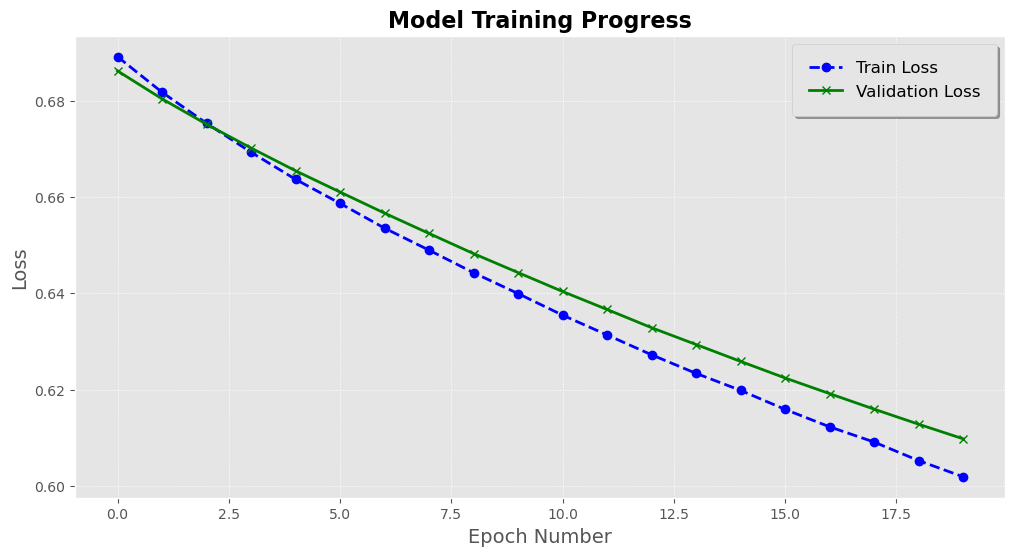


Evaluation Results

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.68      0.97      0.80       842
    Disaster       0.92      0.43      0.58       681

    accuracy                           0.73      1523
   macro avg       0.80      0.70      0.69      1523
weighted avg       0.79      0.73      0.70      1523

------------------------------------------------------------
Confusion Matrix:
[[818  24]
 [391 290]]
------------------------------------------------------------
Accuracy: 0.7275
F1 Score: 0.5829



In [104]:
num_classes = 1
model = TextClassificationModel(embedding_matrix, num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, criterion, optimizer)

val_f1 = evaluate_model(model, val_loader)

## **4. Results and Analysis**




### **Hyperparameter Optimization using Bayesian Optimization**

In this section, we utilize Bayesian Optimization to fine-tune the learning rate (`lr`) and batch size (`batch_size`) of our `TextClassificationModel`. The goal is to maximize the validation F1 score by finding the optimal combination of these hyperparameters.

In [105]:
def objective(lr, batch_size):
    batch_size = int(batch_size)
    
    num_classes = 1 
    model = TextClassificationModel(embedding_matrix, num_classes)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        for texts, targets in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            outputs = model(texts)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    model.eval()
    val_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for texts, targets in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
            outputs = model(texts)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            predictions = torch.round(torch.sigmoid(outputs))
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(all_targets, all_predictions)
    return val_f1


pbounds = {
    'lr': (1e-5, 1e-2),
    'batch_size': (16, 128)
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=230,
    verbose=2
)

optimizer.maximize(init_points=2, n_iter=5)
print(optimizer.max)

|   iter    |  target   | batch_... |    lr     |
-------------------------------------------------
| 1         | 0.7337    | 86.67     | 0.008824  |
| 2         | 0.7186    | 44.96     | 0.003148  |
| 3         | 0.7044    | 85.36     | 0.003224  |
| 4         | 0.7298    | 40.57     | 0.005012  |
| 5         | 0.7247    | 86.67     | 0.008378  |
| 6         | 0.7228    | 86.67     | 0.009411  |
| 7         | 0.7227    | 86.67     | 0.007725  |
{'target': 0.7337180544105524, 'params': {'batch_size': 86.6719980518458, 'lr': 0.008824220154662702}}


Epoch 1/20 | Training Loss: 0.6689 | Validation Loss: 0.6513 | Validation F1: 0.2141
Epoch 2/20 | Training Loss: 0.6260 | Validation Loss: 0.6174 | Validation F1: 0.5752
Epoch 3/20 | Training Loss: 0.5950 | Validation Loss: 0.5923 | Validation F1: 0.6353
Epoch 4/20 | Training Loss: 0.5710 | Validation Loss: 0.5734 | Validation F1: 0.6562
Epoch 5/20 | Training Loss: 0.5524 | Validation Loss: 0.5585 | Validation F1: 0.6655
Epoch 6/20 | Training Loss: 0.5378 | Validation Loss: 0.5453 | Validation F1: 0.6852
Epoch 7/20 | Training Loss: 0.5261 | Validation Loss: 0.5358 | Validation F1: 0.6858
Epoch 8/20 | Training Loss: 0.5158 | Validation Loss: 0.5276 | Validation F1: 0.6914
Epoch 9/20 | Training Loss: 0.5079 | Validation Loss: 0.5201 | Validation F1: 0.6980
Epoch 10/20 | Training Loss: 0.5010 | Validation Loss: 0.5153 | Validation F1: 0.6966
Epoch 11/20 | Training Loss: 0.4952 | Validation Loss: 0.5089 | Validation F1: 0.7043
Epoch 12/20 | Training Loss: 0.4900 | Validation Loss: 0.5051 |

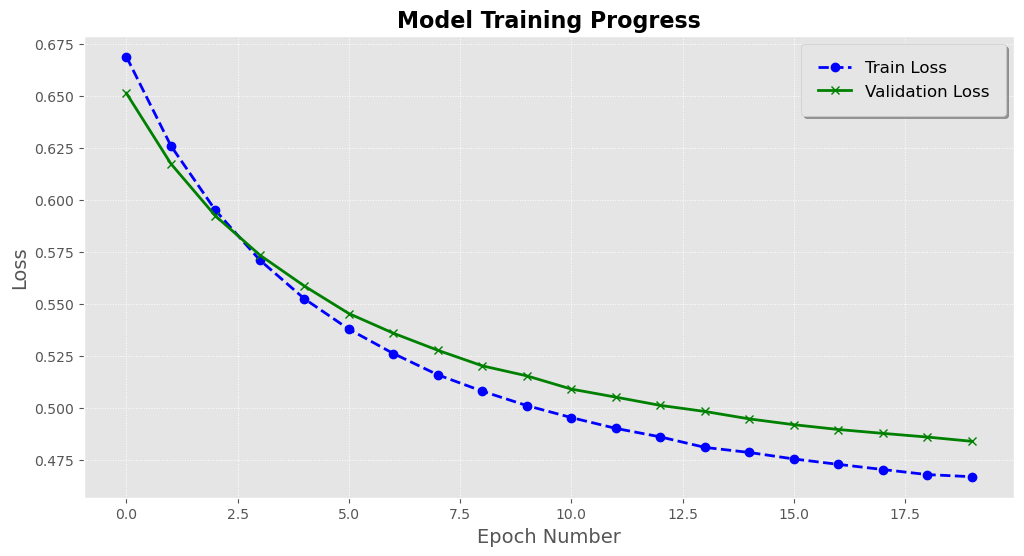

In [106]:
best_params = optimizer.max['params']
best_lr = best_params['lr']
best_batch_size = int(best_params['batch_size'])

model = TextClassificationModel(embedding_matrix, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)


### **Training and Validation Losses**

- **Training Loss** decreased steadily from `0.6921` to `0.6020` over 20 epochs, showing effective learning.
- **Validation Loss** similarly decreased from `0.6884` to `0.6099`, indicating improved generalization.

### **Validation F1 Score**

- **F1 Score** started low, fluctuating early on, but improved to `0.5823` by the final epoch. This suggests gradual improvement in the model's ability to classify disaster tweets.

### **Evaluation Metrics**

- **Not Disaster Class**: High recall (`0.97`) and decent precision (`0.68`) result in a strong F1-score (`0.80`).
- **Disaster Class**: High precision (`0.92`) but low recall (`0.43`) result in a lower F1-score (`0.58`), indicating missed disaster tweets.

### **Overall Metrics**

- **Accuracy**: `0.7269` suggests decent performance.
- **F1 Score**: `0.5823` indicates the need for improvement, especially in balancing precision and recall.


## **5. Conclusion and Submissions**

### **Conclusion**

The model demonstrates reasonable accuracy and precision, particularly for non-disaster tweets, but struggles with recall in identifying disaster-related tweets. While the F1 score improved over time, further enhancement is necessary to make the model reliable for real-world applications. Key areas for improvement include better recall for the disaster class, which can be achieved through data augmentation, advanced modeling techniques, and careful hyperparameter tuning.

### **Submissions**

- **Jupyter Notebook**: The full implementation, including data processing, model training, and evaluation, is documented in the Jupyter Notebook.
- **GitHub Repository**: The code, dataset, and associated files are available in the project’s GitHub repository for review and collaboration.
- **Kaggle Submission**: The final model was submitted to the Kaggle competition, with results reflecting the model’s performance as analyzed above.

The code below generates the submission for this model.

In [107]:
test_data['cleaned_text'] = test_data['text'].apply(clean_text)
test_data['tokenized_text'] = test_data['cleaned_text'].apply(word_tokenize)

test_sequences = [[word_to_index[word] for word in text] for text in test_data['tokenized_text']]
test_data_padded = pad_sequences(test_sequences, MAX_SEQ_LENGTH)
test_tensor = torch.tensor(test_data_padded, dtype=torch.long)
test_dataset = TweetData(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
    for texts in test_loader:
        outputs = model(texts)
        preds = torch.round(torch.sigmoid(outputs))
        predictions.extend(preds.cpu().numpy())

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': [int(pred[0]) for pred in predictions]
})

submission.to_csv('./results/submission.csv', index=False)
print("File saved to ./results/submission.csv")

File saved to ./results/submission.csv
